<a href="https://colab.research.google.com/github/Changho0514/web1/blob/main/%5BQUS%5D_word2vec_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Word2Vec (CBOW, Skip-gram)**
1. 라이브러리를 활용하지 않고 CBOW, Skip-gram 모델을 각각 구현, 학습합니다.
3. gensim 라이브러리를 활용하여 CBOW, Skip-gram 모델을 학습하고 시각화합니다.

## **1. Word2Vec 구현 및 학습**

### 1.1 필요한 패키지 import

In [1]:
!pip install konlpy

In [2]:
from tqdm import tqdm
from konlpy.tag import Okt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### 1.2 Dataset 구축

Sample 데이터를 확인합니다.
데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [3]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

KoNLPy 패키지에서 제공하는 Twitter(Okt) tokenizer를 사용하여 tokenization합니다.

In [4]:
tokenizer = Okt()   # 단어 분리하기 위한 툴. 기본형으로 저장됨 

In [5]:
def make_tokenized(data):
    tokenized = []
    for sent in tqdm(data):
        tokens = tokenizer.morphs(sent, stem=True)
        tokenized.append(tokens)

    return tokenized

In [6]:
train_tokenized = make_tokenized(train_data)  

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


tokenize된 데이터를 확인해봅시다. 

In [7]:
train_tokenized

[['정말', '맛있다', '.', '추천', '하다', '.'],
 ['기대하다', '것', '보단', '별로', '이다', '.'],
 ['다',
  '좋다',
  '가격',
  '이',
  '너무',
  '비싸다',
  '다시',
  '가다',
  '싶다',
  '생각',
  '이',
  '안',
  '드네',
  '요',
  '.'],
 ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'],
 ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'],
 ['위생',
  '상태',
  '가',
  '좀',
  '별로',
  '이다',
  '.',
  '좀',
  '더',
  '개선',
  '되다',
  '기르다',
  '바라다',
  '.'],
 ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'],
 ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'],
 ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'],
 ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]

Tokenize 된 단어의 빈도 수를 확인할 수 있는 `word_count` 를 생성합니다.

In [8]:
word_count = defaultdict(int) #default값이 int인 딕셔너리, 값을 지정하지 않았다면 0으로 지정됨

for tokens in tqdm(train_tokenized):
    for token in tokens:
        word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 828.10it/s]


가장 많이 등장한 토큰부터 적게 등장한 토큰 순으로 나열하여 `word_count` 를 확인해 봅니다.  
목적: 각 토큰에 대해서 빈도수를 보고싶은 것.  
딕셔너리로 만들기

In [9]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


각 단어를 정수 값(index) 에 mapping 하는 word to index (`w2i`) 를 생성합니다.

`w2i` 의 전체 크기는 고유한 단어의 개수(vocab size)와 동일합니다.

- 가장 많이 나온 단어가 정수 0, 적게 나온 단어가 정수 n을 부여받도록 해주세요.

In [10]:
w2i = {}
for pair in tqdm(word_count):
    ## TO DO (start) ##
    key, value = pair
    w2i[key] = len(w2i)
    ## TO DO (end) ##

100%|██████████| 60/60 [00:00<00:00, 219023.71it/s]


In [11]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

**Tip** `torch.utils.data.Dataset`


---
파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 Dataset과 DataLoader를 제공합니다.

이 도구를 활용하면 미니 배치 학습, 데이터 셔플, 병렬 처리를 간단히 수행할 수 있습니다. 

Dataset 를 정의하고 이를 DataLoader 에 전달함으로써 사용할 수 있습니다.

파이토치에서 제공하는 Dataset 을 커스텀하여 `CBOWDataset` 과 `SkipGramDataset` 을 정의해 봅시다.

`__init__`, `__len__`, `__getitem__` 을 다시 정의함으로써 커스텀할 수 있습니다.

출처: https://wikidocs.net/55580


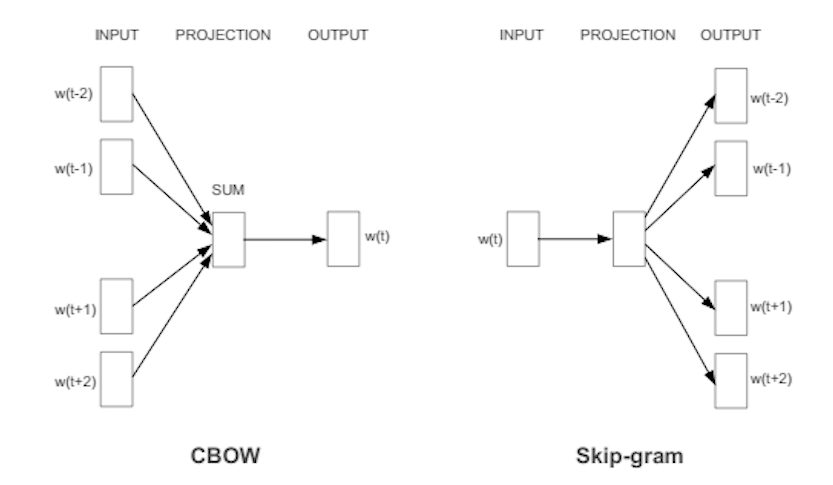

CBOW는 주변 단어를 input으로 넣어서 output으로 중심 단어를 유추한다  
skip-gram은 중심 단어를 Input으로 넣어서 output으로 주변 단어를 유추한다

### 나는 너를 사랑한다  
에서 '너를'이 중심단어, 주변단어는 '나는', '사랑한다'

CBOW 는 window 내에 있는 context word를 가지고 target word 하나를 맞추는 과정에서 학습됩니다.

Skip-gram 은 target word 하나를 가지고 주변 context word 를 맞추는 과정에서 학습됩니다.

In [12]:
# CBOW는 중심단어를 주고(self.y), 주변 단어는 self.x에 들어간다
class CBOWDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2): #window_size는 "정말 맛있습니다 매우 추천합니다 굿" 중심단어가 '매우' 인데 이 앞뒤로 2개 사이즈를 주변단어로 생각한다는 것 
        self.x = []
        self.y = []
        
        ## TO DO (start) ##
        for tokens in train_tokenized:
          # 1. token => integer (w2i 딕셔너리 활용)
          token_ids = [w2i[token] for token in tokens]
          # print(token_ids)

          # 2. 중심단어, 주변단어 -> 리스트에 넣기
          for i, id in enumerate(token_ids):
            # 2. 1 중심단어가 될 수 있는지?        
            if i >= window_size and i < (len(token_ids)-window_size):
              # 나의 답
              # self.x.append(token_ids[i+1][1], token_ids[i+2][1], token_ids[i-1][1], token_ids[i-2][1])
              self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
              self.y.append(id)
        ## TO DO (end) ##
        
        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

[17, 18, 0, 19, 10, 0]  
[20, 21, 22, 4, 2, 0]  
[5, 3, 23, 6, 7, 24, 25, 26, 27, 28, 6, 29, 30, 31, 0]  
[32, 33, 2, 34, 35, 11, 36, 37, 0]  
[8, 1, 9, 1, 5, 38, 0]  
[12, 39, 40, 13, 4, 2, 0, 13, 14, 41, 42, 43, 44, 0]  
[45, 1, 3, 46, 47, 9, 1, 7, 48, 0]  
[49, 15, 11, 10, 8, 1, 50, 1, 9, 1, 5, 3, 0]  
[51, 52, 53, 8, 6, 7, 54, 0, 55, 56, 4, 2, 0]  
[12, 15, 16, 14, 57, 58, 3, 0, 16, 59, 0]  
[]
첫줄 에서 17, 18, 10, 0 은 중심단어가 될 수 없다

In [13]:
cbow_set = CBOWDataset(train_tokenized)
print(list(cbow_set))

[(tensor([17, 18, 19, 10]), tensor(0)), (tensor([18,  0, 10,  0]), tensor(19)), (tensor([20, 21,  4,  2]), tensor(22)), (tensor([21, 22,  2,  0]), tensor(4)), (tensor([5, 3, 6, 7]), tensor(23)), (tensor([ 3, 23,  7, 24]), tensor(6)), (tensor([23,  6, 24, 25]), tensor(7)), (tensor([ 6,  7, 25, 26]), tensor(24)), (tensor([ 7, 24, 26, 27]), tensor(25)), (tensor([24, 25, 27, 28]), tensor(26)), (tensor([25, 26, 28,  6]), tensor(27)), (tensor([26, 27,  6, 29]), tensor(28)), (tensor([27, 28, 29, 30]), tensor(6)), (tensor([28,  6, 30, 31]), tensor(29)), (tensor([ 6, 29, 31,  0]), tensor(30)), (tensor([32, 33, 34, 35]), tensor(2)), (tensor([33,  2, 35, 11]), tensor(34)), (tensor([ 2, 34, 11, 36]), tensor(35)), (tensor([34, 35, 36, 37]), tensor(11)), (tensor([35, 11, 37,  0]), tensor(36)), (tensor([8, 1, 1, 5]), tensor(9)), (tensor([ 1,  9,  5, 38]), tensor(1)), (tensor([ 9,  1, 38,  0]), tensor(5)), (tensor([12, 39, 13,  4]), tensor(40)), (tensor([39, 40,  4,  2]), tensor(13)), (tensor([40, 13,

In [14]:
class SkipGramDataset(Dataset):
    def __init__(self, train_tokenized, window_size=2):
        self.x = []
        self.y = []

        ## TO DO ##
        # start #
        for tokens in train_tokenized:
          # 1. token => integer (w2i 딕셔너리 활용)
          token_ids = [w2i[token] for token in tokens]
          # print(token_ids)

          # 2. 중심단어, 주변단어 -> 리스트에 넣기
          for i, id in enumerate(token_ids):
            # 2.1 중심단어가 될 수 있는지?        
            if i >= window_size and i < (len(token_ids)-window_size):
              
              #2.2 여기!
              # (x중심, y주변)으로 짜기
              for k in range(1, window_size+1):
                self.x.append(id) 
                self.y.append(token_ids[i-k])
                self.x.append(id)
                self.y.append(token_ids[i+k])
              # self.x =    # 중심 단어
              # self.y      # 주변 단어
        #  end  #
        self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
        self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

[(tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(17)), (tensor(0), tensor(10)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(20)), (tensor(22), tensor(2)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(0)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(5)), (tensor(23), tensor(7)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(24)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(25)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(26)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(27)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tens

### 1.3 모델 Class 구현

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


**Tip** `nn.Embedding` 


---


위에서 단어(토큰)을 고유한 정수 값으로 매핑하기 위해 정의한 `w2i` 를 떠올려 봅시다. <br>
입력 시퀀스의 단어를 모델의 입력으로 사용하기 위해서는,

1. `w2i` 를 이용해 각 단어를 고유한 정수 값으로 인코딩합니다.
2. 인코딩된 정수 시퀀스를 임베딩 층에 통과시킵니다.
3. 입력 시퀀스의 길이와 동일한 개수의 임베딩 벡터를 얻습니다. <br>

`nn.Embedding` 은 전체 어휘 집합 개수의 임베딩 벡터들 가운데 각 단어의 인덱스에 해당한는 임베딩 벡터에 접근하는 lookup table 로써 2번을 할 수 있도록 해줍니다. 

임베딩 벡터는 훈련 과정에서 학습됩니다.



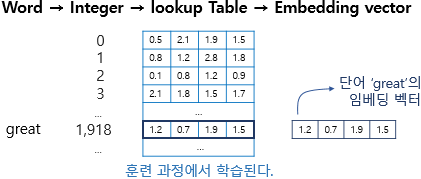

출처: https://wikidocs.net/64779

`nn.Embedding` 의 input 과 output 은 다음과 같습니다.


*   Input: (*), IntTensor or LongTensor of arbitrary shape containing the indices to extract
*   Output: (*, $H$), where * is the input shape and $H =\text{embediding_dim}$

```
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)
tensor([[[-0.0251, -1.6902,  0.7172],
         [-0.6431,  0.0748,  0.6969],
         [ 1.4970,  1.3448, -0.9685],
         [-0.3677, -2.7265, -0.1685]],

        [[ 1.4970,  1.3448, -0.9685],
         [ 0.4362, -0.4004,  0.9400],
         [-0.6431,  0.0748,  0.6969],
         [ 0.9124, -2.3616,  1.1151]]])
```



출처: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html



In [16]:
embedding = nn.Embedding(10, 3) # '10개의 3차원 벡터를 만들어줘'
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 1.7407,  1.6363, -0.4832],
         [ 1.0367, -0.0155,  0.9151],
         [ 0.7659, -0.3500,  0.0325],
         [ 1.4713,  0.2392, -0.8692]],

        [[ 0.7659, -0.3500,  0.0325],
         [-0.0398,  0.4841,  0.6937],
         [ 1.0367, -0.0155,  0.9151],
         [ 0.4129,  0.3048,  0.9201]]], grad_fn=<EmbeddingBackward0>)

In [17]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x):  # x: (B, 2W)
        
        # import pdb; pdb.set_trace()
        ## TO DO ##
        # start #

        # 1. embedding => 벡터 표현 얻기
        embeddings = self.embedding(x) #벡터 표현을 갖고있을 변수 embeddings 설정
        # 2. 벡터들을 더해주기
        embeddings = torch.sum(embeddings, dim=1) # [64, 4, 256]에서 4가 의미하는게 주변 단어 4개(windows=2)였으니까
        # 3. linear layer //embedding = [64, 256]이 됨 
        output = self.linear(embeddings) #[64, 60]이 된다. 60개의 단어를 갖는다는 뜻  

        #  end  #

        
        return output

In [18]:
cbow_loader = DataLoader(cbow_set, batch_size=64)
sample_x, sample_y = next(iter(cbow_loader))
cbow = CBOW(vocab_size=len(w2i), dim=256)
cbow(sample_x)

tensor([[ 1.6110,  1.9637,  0.6831,  ...,  2.0081,  0.5069, -0.4347],
        [ 0.9656,  2.6975, -2.0452,  ...,  3.2632,  1.0581, -1.1832],
        [ 0.1477,  1.3616,  0.3752,  ..., -0.5112, -1.6775,  0.1857],
        ...,
        [-0.2580, -1.1834, -1.2366,  ...,  1.4980,  0.0056, -0.9903],
        [-1.3180, -2.1481, -1.1824,  ...,  0.6805,  1.1052, -0.5184],
        [-0.1753, -0.0069, -2.7139,  ...,  2.6813,  1.8333, -0.5379]],
       grad_fn=<AddmmBackward0>)

In [19]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
        self.linear = nn.Linear(dim, vocab_size)

    # B: batch size, W: window size, d_w: word embedding size, V: vocab size
    def forward(self, x): # x: (B)

        ## TO DO ##
        # start #
        # import pdb; pdb.set_trace()
        embeddings = self.embedding(x)
        output = self.linear(embeddings)

        #  end  #
        
        return output

In [20]:
skipgram_loader = DataLoader(skipgram_set, batch_size=64)
sample_x, sample_y = next(iter(skipgram_loader))
skipgram = SkipGram(vocab_size=len(w2i), dim=256)
skipgram(sample_x)

tensor([[ 0.4324,  0.9707,  0.6968,  ...,  0.5606,  0.3212,  0.4937],
        [ 0.4324,  0.9707,  0.6968,  ...,  0.5606,  0.3212,  0.4937],
        [ 0.4324,  0.9707,  0.6968,  ...,  0.5606,  0.3212,  0.4937],
        ...,
        [-0.5278,  0.0083, -0.6244,  ...,  0.4368,  0.5991, -0.2906],
        [-0.5278,  0.0083, -0.6244,  ...,  0.4368,  0.5991, -0.2906],
        [-0.5278,  0.0083, -0.6244,  ...,  0.4368,  0.5991, -0.2906]],
       grad_fn=<AddmmBackward0>)

### 1.4 모델 학습 

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

**Tip** `torch.utils.data.DataLoader` 


---

Dataloader 는 앞서 정의한 Dataset 를 전달 받아 학습 과정에서 모델의 입력으로 사용할 수 있도록 데이터를 load 해줍니다. 

batch_size 를 정해줌으로써 미니 배치 학습이 가능한 형태로 데이터를 가공합니다.

예를 들어, 전체 데이터 수가 100 개 이고 batch size 가 20인 경우, 데이터는 20개의 데이터가 하나의 배치로 묶여 총 5개 의 배치로 구성됩니다.
즉, (100, ) 사이즈의 데이터가 (5, 20, ) 로 변하게 됩니다.

모델을 학습할 때에는 for loop 을 돌면서 한 iteration 에 하나의 배치를 데이터 로더로부터 전달 받아 모델의 입력으로 사용합니다.


```
# Example of DataLoader usage
for batch in data_loader:
    output = model(batch)
```


In [21]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.


In [22]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(cbow_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)
        output = cbow(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:00<00:00, 171.54it/s]


Train loss: 3.3851635456085205
Train loss: 4.056219100952148
Train loss: 3.857046127319336
Train loss: 5.5737199783325195
Train loss: 3.678243637084961
Train loss: 4.918858528137207
Train loss: 5.32630729675293
Train loss: 4.224360466003418
Train loss: 4.713920593261719
Train loss: 5.161181926727295
Train loss: 4.6192240715026855
Train loss: 5.4019670486450195
Train loss: 5.395505428314209
Train loss: 4.666454315185547
Train loss: 4.6583051681518555
Train loss: 5.14893913269043
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 339.09it/s]

Train loss: 3.2208900451660156
Train loss: 3.927328586578369
Train loss: 3.7246780395507812
Train loss: 5.440969467163086
Train loss: 3.567523956298828
Train loss: 4.629146575927734
Train loss: 5.119905471801758
Train loss: 4.081268310546875
Train loss: 4.579463005065918
Train loss: 4.9616193771362305
Train loss: 4.419289588928223
Train loss: 5.012302398681641
Train loss: 5.241763114929199
Train loss: 4.552600860595703
Train loss: 4.482043266296387
Train loss: 5.018763065338135


##################################################
Epoch: 3


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 3.0613045692443848
Train loss: 3.8020520210266113
Train loss: 3.5947835445404053
Train loss: 5.3092875480651855
Train loss: 3.4586520195007324
Train loss: 4.347187042236328
Train loss: 4.918243408203125
Train loss: 3.940906286239624
Train loss: 4.448957920074463
Train loss: 4.7664408683776855
Train loss: 4.227231979370117
Train loss: 4.635112762451172
Train loss: 5.09055233001709
Train loss: 4.441958427429199
Train loss: 4.309638023376465
Train loss: 4.891375541687012


100%|██████████| 16/16 [00:00<00:00, 446.39it/s]


##################################################
Epoch: 4


100%|██████████| 16/16 [00:00<00:00, 234.07it/s]


Train loss: 2.9066338539123535
Train loss: 3.6802449226379395
Train loss: 3.4674081802368164
Train loss: 5.178668975830078
Train loss: 3.351644515991211
Train loss: 4.073721885681152
Train loss: 4.721580505371094
Train loss: 3.803359031677246
Train loss: 4.322239875793457
Train loss: 4.575927734375
Train loss: 4.04336404800415
Train loss: 4.272713661193848
Train loss: 4.941777229309082
Train loss: 4.334421157836914
Train loss: 4.141435623168945
Train loss: 4.766700267791748
##################################################
Epoch: 5


100%|██████████| 16/16 [00:00<00:00, 385.23it/s]

Train loss: 2.7571141719818115
Train loss: 3.5617713928222656
Train loss: 3.342599391937256
Train loss: 5.049107551574707
Train loss: 3.246520757675171
Train loss: 3.809835433959961
Train loss: 4.53020715713501
Train loss: 3.668700695037842
Train loss: 4.199177265167236
Train loss: 4.390470504760742
Train loss: 3.8683385848999023
Train loss: 3.9282281398773193
Train loss: 4.795362949371338
Train loss: 4.2298760414123535
Train loss: 3.9778053760528564
Train loss: 4.64463996887207
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [23]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
    print("#" * 50)
    print(f"Epoch: {e}")
    for batch in tqdm(skipgram_loader):
        x, y = batch
        x, y = x.to(device), y.to(device) # (B, W), (B)
        output = skipgram(x)  # (B, V)

        optim.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optim.step()

        print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.412774085998535
Train loss: 4.484925270080566
Train loss: 4.81033992767334
Train loss: 4.76298189163208
Train loss: 3.9532711505889893
Train loss: 4.109473705291748
Train loss: 3.8395776748657227
Train loss: 3.9259257316589355
Train loss: 4.001883506774902
Train loss: 4.39670467376709
Train loss: 4.49104642868042
Train loss: 4.329383850097656
Train loss: 4.49345064163208
Train loss: 3.758206367492676
Train loss: 4.382747650146484
Train loss: 4.5534892082214355
Train loss: 4.2382097244262695
Train loss: 4.461404800415039
Train loss: 3.818362236022949
Train loss: 4.339934825897217
Train loss: 4.173030376434326
Train loss: 3.7755696773529053
Train loss: 4.142513275146484
Train loss: 4.019070625305176
Train loss: 4.536371231079102
Train loss: 4.5141119956970215
Train loss: 4.141043186187744
Train loss: 4.219099521636963
Train loss: 4.730193138122559
Train loss: 4.113398551940918
Train loss: 4.428716659545898
Train loss: 3.928546667098999
Train loss: 4.1241230964660645
Train l

100%|██████████| 64/64 [00:00<00:00, 440.53it/s]


Train loss: 4.269676208496094
Train loss: 4.487614631652832
Train loss: 4.302535533905029
Train loss: 4.677045822143555
Train loss: 4.521509170532227
Train loss: 3.820033550262451
Train loss: 3.936980724334717
Train loss: 3.8648953437805176
Train loss: 4.656122207641602
##################################################
Epoch: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.386712074279785
Train loss: 4.435376167297363
Train loss: 4.780960559844971
Train loss: 4.691077709197998
Train loss: 3.921077251434326
Train loss: 4.070250034332275

 72%|███████▏  | 46/64 [00:00<00:00, 456.02it/s]


Train loss: 3.8046278953552246
Train loss: 3.896162509918213
Train loss: 3.976484537124634
Train loss: 4.368732929229736
Train loss: 4.461035251617432
Train loss: 4.295424461364746
Train loss: 4.462738990783691
Train loss: 3.725959300994873
Train loss: 4.341187477111816
Train loss: 4.522125720977783
Train loss: 4.209795951843262
Train loss: 4.424056529998779
Train loss: 3.7872986793518066
Train loss: 4.308894157409668
Train loss: 4.090639591217041
Train loss: 3.689358711242676
Train loss: 4.09320592880249
Train loss: 3.9913628101348877
Train loss: 4.493369102478027
Train loss: 4.44356107711792
Train loss: 4.09338903427124
Train loss: 4.190280437469482
Train loss: 4.683515548706055
Train loss: 4.0890092849731445
Train loss: 4.3978271484375
Train loss: 3.8988118171691895
Train loss: 4.088562965393066
Train loss: 4.35234260559082
Train loss: 4.3031005859375
Train loss: 4.353830337524414
Train loss: 3.9834694862365723
Train loss: 4.543308734893799
Train loss: 4.436615943908691
Train loss:

100%|██████████| 64/64 [00:00<00:00, 336.09it/s]


Train loss: 3.773509979248047
Train loss: 4.02045202255249
Train loss: 4.43445348739624
Train loss: 4.326536178588867
Train loss: 4.1214375495910645
Train loss: 4.349700450897217
Train loss: 3.9237871170043945
Train loss: 3.8951263427734375
Train loss: 4.126762866973877
Train loss: 4.247681140899658
Train loss: 4.419980049133301
Train loss: 4.269495010375977
Train loss: 4.646003246307373
Train loss: 4.484131813049316
Train loss: 3.792377233505249
Train loss: 3.911505699157715
Train loss: 3.8463146686553955
Train loss: 4.607560634613037
##################################################
Epoch: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.361071586608887


 61%|██████    | 39/64 [00:00<00:00, 387.20it/s]

Train loss: 4.386081218719482
Train loss: 4.751664638519287
Train loss: 4.619998931884766
Train loss: 3.8891243934631348
Train loss: 4.031692028045654
Train loss: 3.7702202796936035
Train loss: 3.8666021823883057
Train loss: 3.9512481689453125
Train loss: 4.340885162353516
Train loss: 4.431173324584961
Train loss: 4.26162576675415
Train loss: 4.432494163513184
Train loss: 3.6939711570739746
Train loss: 4.299925327301025
Train loss: 4.4910736083984375
Train loss: 4.181578636169434
Train loss: 4.386899471282959
Train loss: 3.7566308975219727
Train loss: 4.278003692626953
Train loss: 4.009209156036377
Train loss: 3.6055493354797363
Train loss: 4.0443902015686035
Train loss: 3.9638149738311768
Train loss: 4.450762748718262
Train loss: 4.373871803283691
Train loss: 4.04624080657959
Train loss: 4.161921501159668
Train loss: 4.637198448181152
Train loss: 4.06487512588501
Train loss: 4.3670783042907715
Train loss: 3.8693554401397705
Train loss: 4.05327844619751
Train loss: 4.318037986755371
Tr

100%|██████████| 64/64 [00:00<00:00, 410.87it/s]


Train loss: 4.001234531402588
Train loss: 4.366674900054932
Train loss: 3.9613547325134277
Train loss: 4.167032241821289
Train loss: 3.6865673065185547
Train loss: 3.9707388877868652
Train loss: 4.407710075378418
Train loss: 4.290859699249268
Train loss: 4.083111763000488
Train loss: 4.306543350219727
Train loss: 3.8953235149383545
Train loss: 3.8753232955932617
Train loss: 4.101219177246094
Train loss: 4.225779056549072
Train loss: 4.353176116943359
Train loss: 4.236832141876221
Train loss: 4.615204334259033
Train loss: 4.446969985961914
Train loss: 3.764899730682373
Train loss: 3.8863701820373535
Train loss: 3.8281633853912354
Train loss: 4.559430122375488
##################################################
Epoch: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.335845947265625
Train loss: 4.33704948425293
Train loss: 4.7224531173706055
Train loss: 4.549798011779785
Train loss: 3.8574142456054688
Train loss: 3.993809700012207
Train loss: 3.736358165740967
Train loss: 3.8372485637664795
Train loss: 3.9261741638183594

 66%|██████▌   | 42/64 [00:00<00:00, 414.05it/s]


Train loss: 4.313161849975586
Train loss: 4.401461601257324
Train loss: 4.227993011474609
Train loss: 4.402718544006348
Train loss: 3.6622445583343506
Train loss: 4.258969306945801
Train loss: 4.460338115692139
Train loss: 4.153557777404785
Train loss: 4.349937438964844
Train loss: 3.726362705230713
Train loss: 4.247262954711914
Train loss: 3.9288182258605957
Train loss: 3.524254083633423
Train loss: 3.9960803985595703
Train loss: 3.9364306926727295
Train loss: 4.4085588455200195
Train loss: 4.3050994873046875
Train loss: 3.9996161460876465
Train loss: 4.134019374847412
Train loss: 4.591253757476807
Train loss: 4.040996074676514
Train loss: 4.33647346496582
Train loss: 3.840179681777954
Train loss: 4.018272876739502
Train loss: 4.284112453460693
Train loss: 4.228797912597656
Train loss: 4.284675121307373
Train loss: 3.886821985244751
Train loss: 4.434363842010498
Train loss: 4.378697395324707
Train loss: 4.536068916320801
Train loss: 4.262306213378906
Train loss: 3.5817484855651855
Tr

100%|██████████| 64/64 [00:00<00:00, 371.22it/s]



Train loss: 3.8670506477355957
Train loss: 3.8559410572052
Train loss: 4.075813293457031
Train loss: 4.203970909118652
Train loss: 4.287261962890625
Train loss: 4.204552173614502
Train loss: 4.584650039672852
Train loss: 4.410028457641602
Train loss: 3.737602710723877
Train loss: 3.8615732192993164
Train loss: 3.810431957244873
Train loss: 4.511737823486328
##################################################
Epoch: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Train loss: 4.311031341552734
Train loss: 4.288290977478027
Train loss: 4.6933274269104
Train loss: 4.480535507202148
Train loss: 3.8259506225585938
Train loss: 3.9566121101379395
Train loss: 3.7030467987060547
Train loss: 3.8081045150756836
Train loss: 3.901261568069458
Train loss: 4.285566329956055
Train loss: 4.371899604797363
Train loss: 4.194527626037598
Train loss: 4.3734130859375
Train loss: 3.6307830810546875
Train loss: 4.218328475952148
Train loss: 4.429924011230469
Train loss: 4.125732898712158
Train loss: 4.313175201416016
Train loss: 3.6964962482452393


100%|██████████| 64/64 [00:00<00:00, 571.08it/s]

Train loss: 4.216671943664551
Train loss: 3.849550485610962
Train loss: 3.4455957412719727
Train loss: 3.9482946395874023
Train loss: 3.9092109203338623
Train loss: 4.366767883300781
Train loss: 4.237303733825684
Train loss: 3.9535322189331055
Train loss: 4.106569290161133
Train loss: 4.545693397521973
Train loss: 4.0173726081848145
Train loss: 4.306014060974121
Train loss: 3.8112847805023193
Train loss: 3.9835495948791504
Train loss: 4.250572204589844
Train loss: 4.1920623779296875
Train loss: 4.250457286834717
Train loss: 3.8398993015289307
Train loss: 4.3829522132873535
Train loss: 4.35024881362915
Train loss: 4.504535675048828
Train loss: 4.2394514083862305
Train loss: 3.5454928874969482
Train loss: 3.8747622966766357
Train loss: 4.256642818450928
Train loss: 3.719822645187378
Train loss: 4.007333755493164
Train loss: 3.520963430404663
Train loss: 3.8728742599487305
Train loss: 4.354556560516357
Train loss: 4.221024036407471
Train loss: 4.008426666259766
Train loss: 4.2216997146606

### 1.5 테스트

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [24]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = cbow.embedding(input_id)

    print(f"Word: {word}")
    print(emb.squeeze(0))

Word: 음식
tensor([ 0.2449, -1.3306,  0.9265, -0.8492, -1.0746, -0.6219,  0.1393,  1.3252,
        -0.4218, -0.5153, -0.7044, -0.4300,  0.2803, -1.5810, -0.0364,  0.6941,
         2.6620,  0.3427,  0.5508, -0.1912, -0.3278,  0.3970,  0.9122,  0.9230,
         1.4270, -0.5188, -1.1903, -0.4654,  0.8021, -0.5123, -1.2608,  2.4610,
        -0.8837,  0.9114, -0.5185,  0.1186, -0.6277,  1.5066, -1.4712,  1.4513,
        -1.0748,  0.8127,  0.4623, -1.1953,  0.5021, -0.8800,  0.7874,  1.0231,
        -0.4771, -0.0560, -0.2483, -0.1670,  0.1708,  0.6910, -1.6905,  0.8516,
        -1.2945, -0.7784, -0.0921, -0.2643, -1.2518, -0.2939,  0.8031, -0.7087,
        -0.4606,  0.2068,  1.7111,  0.0448,  0.0709,  2.3057,  0.4375, -0.1735,
        -0.6394, -0.4977, -0.5806,  0.5690, -0.9318,  1.4501,  0.6759,  0.4802,
         0.2585, -1.2619,  0.9885, -0.4609,  0.6667,  0.3961, -0.3991, -0.8461,
         1.1024, -0.9006, -0.2356, -0.1737, -2.2562,  0.2946, -1.7781,  1.2225,
         1.5176,  0.2725, -0.06

In [25]:
for word in test_words:
    input_id = torch.LongTensor([w2i[word]]).to(device)
    emb = skipgram.embedding(input_id)

    print(f"Word: {word}")
    print(max(emb.squeeze(0)))

Word: 음식
tensor(3.1553, grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.7224, grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.3840, grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.6414, grad_fn=<UnbindBackward0>)
Word: 가격
tensor(2.7044, grad_fn=<UnbindBackward0>)


## **2. gensim library 를 활용한 word2vec 학습 및 시각화**

### 2.1 필요한 패키지 import

In [29]:
# To ignore deprecated warnings
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  
import nltk
from nltk.corpus import movie_reviews # corpus 를 가져오는 용도 
from sklearn.manifold import TSNE # 시각화를 위한 TSNE 사용 
from sklearn.metrics import accuracy_score # accuracy score 를 계산하기 위한 metric 라이브러리 불러오기 
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from torch.utils import data # pytorch data class 
import torch.nn as nn # pytorch neural network 불러오기 
import torch.nn.utils.rnn as rnn_utils # rnn utils
import torch

import pickle

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### 2.2 Word embedding 학습

In [30]:
# 파라메터값 지정
num_features = 300 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 한 문장에 대한 최소 문자 수
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [31]:
# preparing data
sentences = []
pos_data = open("./data/pos_train.txt").readlines()
neg_data = open("./data/neg_train.txt").readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(line.strip().split(' '))

FileNotFoundError: ignored

In [32]:
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

# CBOW 모델 학습
CBOW = word2vec.Word2Vec(sentences,
                              sg = 0, # CBOW
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

2021-12-29 02:47:39,840 : INFO : collecting all words and their counts
2021-12-29 02:47:39,842 : INFO : collected 0 word types from a corpus of 0 raw words and 0 sentences
2021-12-29 02:47:39,844 : INFO : Loading a fresh vocabulary
2021-12-29 02:47:39,845 : INFO : effective_min_count=10 retains 0 unique words (0% of original 0, drops 0)
2021-12-29 02:47:39,850 : INFO : effective_min_count=10 leaves 0 word corpus (0% of original 0, drops 0)
2021-12-29 02:47:39,852 : INFO : deleting the raw counts dictionary of 0 items
2021-12-29 02:47:39,855 : INFO : sample=0.75 downsamples 0 most-common words
2021-12-29 02:47:39,856 : INFO : downsampling leaves estimated 0 word corpus (0.0% of prior 0)
2021-12-29 02:47:39,858 : INFO : estimated required memory for 0 words and 300 dimensions: 0 bytes
2021-12-29 02:47:39,859 : INFO : resetting layer weights


RuntimeError: ignored

### 2.3 학습한 embedding 확인 및 시각화


특정 단어와 유사한 의미를 가지는 단어를 추출해 봄으로써 임베딩에 단어의 의미가 잘 학습되었는지 확인합니다.

In [ ]:
skip_gram.wv.most_similar("man") # skip-gram 모델을 이용하여 'man'에 가장 유사한 단어 추출

In [ ]:
CBOW.wv.most_similar("man") # CBOW 모델을 이용하여 'man'에 가장 유사한 단어 추출

300차원의 단어 임베딩을 2차원으로 차원 축소하여 시각화함으로써 임베딩 벡터의 분포를 확인해 봅니다.

**Tip** `t-SNE` 


---

t-SNE 는 차원 축소 (dimensionality reduction)와 시각화(visualization) 방법입니다.

Stochastic Neighboring Embedding(SNE) 라는 고차원 공간에 존재하는 데이터 $x$의 이웃 간의 거리를 최대한 보존하는 저차원의 $y$를 학습하는 방법입니다.

고차원 공간에서 특정 개체 $x_i$ 가 주어졌을 때 이웃 객체 $x_j$ 가 선택될 확률을 $p_{j|i}$, 저차원 공간에서 특정 개체 $y_i$ 가 주어졌을 때 이웃 객체 $y_j$ 가 선택될 확률을 $q_{j|i}$ 라고 한다면 SNE 는 $p$ 와 $q$의 분포 차이를 최대한 작게 함으로써 학습됩니다. 

두 확률분포의 유사도는 Kullback-Leibler divergence 라는 지표를 활용합니다.

SNE 는 가우시안 분포를 전제하는데, 가우시안 분포가 아닌 t분포를 가정하는 것이 t-SNE입니다.

출처: https://ratsgo.github.io/machine%20learning/2017/04/28/tSNE/

In [ ]:
def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에대해 단어 labeling

    plt.show()

In [ ]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

In [ ]:
# CBOW 시각화(TSNE)
vocab = list(CBOW.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화